<a href="https://colab.research.google.com/github/blakelobato/DS-Unit-2-Kaggle-Challenge/blob/master/Blake_Lobato_Sprint_Challenge_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science, Unit 2_
 
# Sprint Challenge: Predict Steph Curry's shots 🏀

For your Sprint Challenge, you'll use a dataset with all Steph Curry's NBA field goal attempts. (Regular season and playoff games, from October 28, 2009, through June 5, 2019.) 

You'll predict whether each shot was made, using information about the shot and the game. This is hard to predict! Try to get above 60% accuracy. The dataset was collected with the [nba_api](https://github.com/swar/nba_api) Python library.

In [0]:
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

In [0]:
# Read data
import pandas as pd
url = 'https://drive.google.com/uc?export=download&id=1fL7KPyxgGYfQDsuJoBWHIWwCAf-HTFpX'
df = pd.read_csv(url)

# Check data shape
assert df.shape == (13958, 20)

To demonstrate mastery on your Sprint Challenge, do all the required, numbered instructions in this notebook.

To earn a score of "3", also do all the stretch goals.

You are permitted and encouraged to do as much data exploration as you want.

**1. Begin with baselines for classification.** Your target to predict is `shot_made_flag`. What is your baseline accuracy, if you guessed the majority class for every prediction?

**2. Hold out your test set.** Use the 2018-19 season to test. NBA seasons begin in October and end in June. You'll know you've split the data correctly when your test set has 1,709 observations.

**3. Engineer new feature.** Engineer at least **1** new feature, from this list, or your own idea.
- **Homecourt Advantage**: Is the home team (`htm`) the Golden State Warriors (`GSW`) ?
- **Opponent**: Who is the other team playing the Golden State Warriors?
- **Seconds remaining in the period**: Combine minutes remaining with seconds remaining, to get the total number of seconds remaining in the period.
- **Seconds remaining in the game**: Combine period, and seconds remaining in the period, to get the total number of seconds remaining in the game. A basketball game has 4 periods, each 12 minutes long.
- **Made previous shot**: Was Steph Curry's previous shot successful?

**4. Decide how to validate** your model. Choose one of the following options. Any of these options are good. You are not graded on which you choose.
- **Train/validate/test split: train on the 2009-10 season through 2016-17 season, validate with the 2017-18 season.** You'll know you've split the data correctly when your train set has 11,081 observations, and your validation set has 1,168 observations.
- **Train/validate/test split: random 80/20%** train/validate split.
- **Cross-validation** with independent test set. You may use any scikit-learn cross-validation method.

**5.** Use a scikit-learn **pipeline** to **encode categoricals** and fit a **Decision Tree** or **Random Forest** model.

**6.** Get your model's **validation accuracy.** (Multiple times if you try multiple iterations.) 

**7.** Get your model's **test accuracy.** (One time, at the end.)


**8.** Given a **confusion matrix** for a hypothetical binary classification model, **calculate accuracy, precision, and recall.**

### Stretch Goals
- Engineer 4+ new features total, either from the list above, or your own ideas.
- Make 2+ visualizations to explore relationships between features and target.
- Optimize 3+ hyperparameters by trying 10+ "candidates" (possible combinations of hyperparameters). You can use `RandomizedSearchCV` or do it manually.
- Get and plot your model's feature importances.



In [3]:
df.head()

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,game_date,htm,vtm,season_type,scoremargin_before_shot
0,20900015,4,Stephen Curry,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,2009-10-28,GSW,HOU,Regular Season,2.0
1,20900015,17,Stephen Curry,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,1,2009-10-28,GSW,HOU,Regular Season,0.0
2,20900015,53,Stephen Curry,1,6,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-60,129,0,2009-10-28,GSW,HOU,Regular Season,-4.0
3,20900015,141,Stephen Curry,2,9,49,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-172,82,0,2009-10-28,GSW,HOU,Regular Season,-4.0
4,20900015,249,Stephen Curry,2,2,19,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-68,148,0,2009-10-28,GSW,HOU,Regular Season,0.0


## 1. Begin with baselines for classification. 

>Your target to predict is `shot_made_flag`. What would your baseline accuracy be, if you guessed the majority class for every prediction?

In [4]:
#start with baseline 
df.shot_made_flag.value_counts(normalize=True)

0    0.527081
1    0.472919
Name: shot_made_flag, dtype: float64

In [0]:
#misses 52.7081% of shots as our baseline in the majority class.

## 2. Hold out your test set.

>Use the 2018-19 season to test. NBA seasons begin in October and end in June. You'll know you've split the data correctly when your test set has 1,709 observations.

In [0]:
df.game_date = pd.to_datetime(arg=df['game_date'], infer_datetime_format=True)
#year - month - day

In [0]:
df['year'] = df.game_date.dt.year

In [0]:
df['month'] = df.game_date.dt.month

In [0]:
test_2018 = df[(df['year'] == 2018) & (df['month'] > 9)] 

In [0]:

test_2019 = df[(df['year'] == 2019) & (df['month'] < 7)] 


In [0]:
test = pd.concat([test_2018, test_2019])

In [12]:
test.shape

(1709, 22)

## 3. Engineer new feature.

>Engineer at least **1** new feature, from this list, or your own idea.
>
>- **Homecourt Advantage**: Is the home team (`htm`) the Golden State Warriors (`GSW`) ?
>- **Opponent**: Who is the other team playing the Golden State Warriors?
>- **Seconds remaining in the period**: Combine minutes remaining with seconds remaining, to get the total number of seconds remaining in the period.
>- **Seconds remaining in the game**: Combine period, and seconds remaining in the period, to get the total number of seconds remaining in the game. A basketball game has 4 periods, each 12 minutes long.
>- **Made previous shot**: Was Steph Curry's previous shot successful?

    

In [0]:
df['homecourt_adv'] =  (df['htm'] == 'GSW')

In [14]:
df.head(10)

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,game_date,htm,vtm,season_type,scoremargin_before_shot,year,month,homecourt_adv
0,20900015,4,Stephen Curry,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,2009-10-28,GSW,HOU,Regular Season,2.0,2009,10,True
1,20900015,17,Stephen Curry,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,1,2009-10-28,GSW,HOU,Regular Season,0.0,2009,10,True
2,20900015,53,Stephen Curry,1,6,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-60,129,0,2009-10-28,GSW,HOU,Regular Season,-4.0,2009,10,True
3,20900015,141,Stephen Curry,2,9,49,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-172,82,0,2009-10-28,GSW,HOU,Regular Season,-4.0,2009,10,True
4,20900015,249,Stephen Curry,2,2,19,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-68,148,0,2009-10-28,GSW,HOU,Regular Season,0.0,2009,10,True
5,20900015,277,Stephen Curry,2,0,34,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),Less Than 8 ft.,4,39,15,0,2009-10-28,GSW,HOU,Regular Season,4.0,2009,10,True
6,20900015,413,Stephen Curry,4,10,26,Pullup Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-64,149,1,2009-10-28,GSW,HOU,Regular Season,-9.0,2009,10,True
7,20900015,453,Stephen Curry,4,6,31,Pullup Jump shot,2PT Field Goal,Mid-Range,Right Side Center(RC),16-24 ft.,17,118,123,1,2009-10-28,GSW,HOU,Regular Season,-6.0,2009,10,True
8,20900015,487,Stephen Curry,4,2,25,Pullup Jump shot,2PT Field Goal,Mid-Range,Right Side Center(RC),16-24 ft.,20,121,162,1,2009-10-28,GSW,HOU,Regular Season,-9.0,2009,10,True
9,20900015,490,Stephen Curry,4,1,47,Pullup Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-125,134,1,2009-10-28,GSW,HOU,Regular Season,-7.0,2009,10,True


In [0]:
## vtm is basically the opponent class because it tells who the team plays

In [0]:
## seconds_remaining and minutes_remaining in the df already too

In [0]:
df['total_minutes_left'] = (12*df['period'] + df['minutes_remaining'])

In [0]:
df['seconds_left_in_period'] = df['minutes_remaining']*60 + df['seconds_remaining']

In [0]:
df['total_seconds_left'] =  (12*df['period'] + df['minutes_remaining'])* 60 + df['seconds_remaining']

In [0]:
df['leading_game'] = (df['scoremargin_before_shot'] > 0)
#column I made to determine if GSW is winning at time of shot or not

In [21]:
df.head(5)

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,game_date,htm,vtm,season_type,scoremargin_before_shot,year,month,homecourt_adv,total_minutes_left,seconds_left_in_period,total_seconds_left,leading_game
0,20900015,4,Stephen Curry,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,2009-10-28,GSW,HOU,Regular Season,2.0,2009,10,True,23,685,1405,True
1,20900015,17,Stephen Curry,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,1,2009-10-28,GSW,HOU,Regular Season,0.0,2009,10,True,21,571,1291,False
2,20900015,53,Stephen Curry,1,6,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-60,129,0,2009-10-28,GSW,HOU,Regular Season,-4.0,2009,10,True,18,362,1082,False
3,20900015,141,Stephen Curry,2,9,49,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-172,82,0,2009-10-28,GSW,HOU,Regular Season,-4.0,2009,10,True,33,589,2029,False
4,20900015,249,Stephen Curry,2,2,19,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-68,148,0,2009-10-28,GSW,HOU,Regular Season,0.0,2009,10,True,26,139,1579,False


In [0]:
#for test later we need to do the test data frames with the additional info
test_2018 = df[(df['year'] == 2018) & (df['month'] > 9)] 
test_2019 = df[(df['year'] == 2019) & (df['month'] < 7)] 
test = pd.concat([test_2018, test_2019])
game_date_drop = 'game_date'
test = test.drop(columns=game_date_drop)


In [23]:
test.shape

(1709, 26)

In [0]:
# How would one go about calculating the made previous shot example?!? 

## **4. Decide how to validate** your model. 

>Choose one of the following options. Any of these options are good. You are not graded on which you choose.
>
>- **Train/validate/test split: train on the 2009-10 season through 2016-17 season, validate with the 2017-18 season.** You'll know you've split the data correctly when your train set has 11,081 observations, and your validation set has 1,168 observations.
>- **Train/validate/test split: random 80/20%** train/validate split.
>- **Cross-validation** with independent test set. You may use any scikit-learn cross-validation method.

In [25]:
#train/validate/test split with data 
#choose the 80/20 split
from sklearn.model_selection import train_test_split

# Split train into train & val
train, val = train_test_split(df, train_size=0.80, test_size=0.20, 
                              stratify=df['shot_made_flag'], random_state=42)

train.shape, val.shape, test.shape

#also very close to the train/validate/test split option so we are happy with that

((11166, 27), (2792, 27), (1709, 26))

In [0]:
game_date_drop = 'game_date'
train = train.drop(columns=game_date_drop)
val = val.drop(columns=game_date_drop)

In [27]:
train.shape, val.shape, test.shape


((11166, 26), (2792, 26), (1709, 26))

## 5. Use a scikit-learn pipeline to encode categoricals and fit a Decision Tree or Random Forest model.

In [35]:
%%time

### try ordinal encoding
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

target = 'shot_made_flag'
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test

# pipeline, but with ordinal encoder
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    RandomForestClassifier(n_estimators=250, bootstrap=True, max_depth=12, min_samples_leaf=1, min_samples_split=3, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))




Validation Accuracy 0.6608166189111748
CPU times: user 6.2 s, sys: 70 ms, total: 6.27 s
Wall time: 3.82 s


In [0]:
#n_estimators, median = 100; 64.86
#150, 30, 1, 5, = 65.26
#250 20 1 5 = 65.40
#250, 20, 1, 3, = 65.47
#500, 20, 1, 3, ==65.54
#250, 12, 1, 3, == 66.08

In [0]:
y_pred = pipeline.predict(X_test)

## 6.Get your model's validation accuracy

> (Multiple times if you try multiple iterations.)

In [36]:
print('Validation Accuracy', pipeline.score(X_val, y_val)*100, '%')

Validation Accuracy 66.08166189111748 %


## 7. Get your model's test accuracy

> (One time, at the end.)

In [37]:
%%time

### try ordinal encoding
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

target = 'shot_made_flag'
X_train = train.drop(columns=target)
y_train = train[target]
y_test = test[target]
X_test = test.drop(columns=target)

# pipeline, but with ordinal encoder
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=500, bootstrap=True, max_depth=15, min_samples_leaf=1, min_samples_split=3, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
print('Test Accuracy', pipeline.score(X_test, y_test))

#Lets GO! 82% accurate on the test set thats awesome


Test Accuracy 0.8215330602691633
CPU times: user 13.7 s, sys: 147 ms, total: 13.8 s
Wall time: 7.96 s


## 8. Given a confusion matrix, calculate accuracy, precision, and recall.

Imagine this is the confusion matrix for a binary classification model. Use the confusion matrix to calculate the model's accuracy, precision, and recall.

<table>
  <tr>
    <td colspan="2" rowspan="2"></td>
    <td colspan="2">Predicted</td>
  </tr>
  <tr>
    <td>Negative</td>
    <td>Positive</td>
  </tr>
  <tr>
    <td rowspan="2">Actual</td>
    <td>Negative</td>
    <td style="border: solid">85</td>
    <td style="border: solid">58</td>
  </tr>
  <tr>
    <td>Positive</td>
    <td style="border: solid">8</td>
    <td style="border: solid"> 36</td>
  </tr>
</table>

In [39]:
!pip install scikit-plot

In [55]:
!pip install matplotlib==3.1.0

     |████████████████████████████████| 13.1MB 184kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: matplotlib 3.1.1
    Uninstalling matplotlib-3.1.1:
      Successfully uninstalled matplotlib-3.1.1


In [0]:
y_pred = pipeline.predict(X_val)

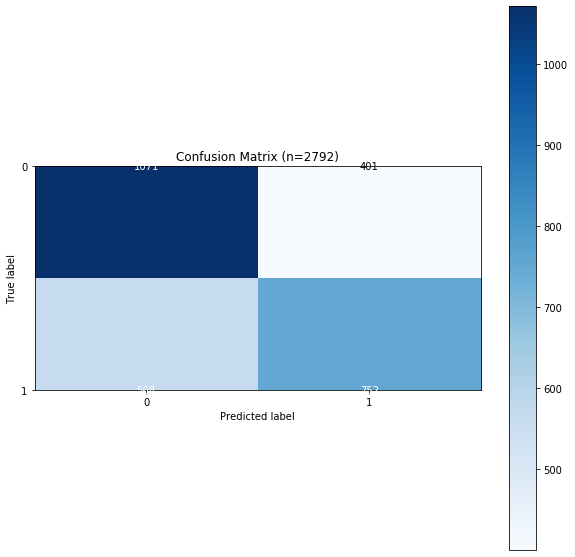

In [50]:
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(y_val, y_pred, 
                                    figsize=(10,10),
                                    title=f'Confusion Matrix (n={len(y_val)})',
                                    normalize=False);

In [51]:
# Compute the confusion_matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_val, y_pred)

array([[1071,  401],
       [ 568,  752]])

In [52]:
# Get the unique labels
from sklearn.utils.multiclass import unique_labels
unique_labels(y_val)

array([0, 1], dtype=int64)

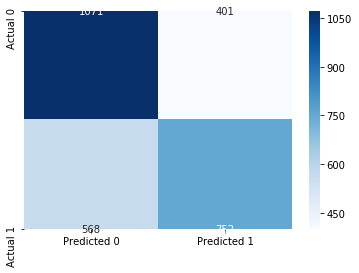

In [54]:
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred):
  labels = unique_labels(y_true)
  columns = [f'Predicted {label}' for label in labels]
  index = [f'Actual {label}' for label in labels]
  df = pd.DataFrame(confusion_matrix(y_true, y_pred),
                    columns = columns,
                    index = index)
  return sns.heatmap(df, annot=True, fmt='d', cmap='Blues')

plot_confusion_matrix(y_val, y_pred);

### Calculate accuracy 

In [63]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))

#accuracy is 65%

              precision    recall  f1-score   support

           0       0.65      0.73      0.69      1472
           1       0.65      0.57      0.61      1320

    accuracy                           0.65      2792
   macro avg       0.65      0.65      0.65      2792
weighted avg       0.65      0.65      0.65      2792



### Calculate precision

In [0]:
correct_made = 762
correct_miss = 1071

In [0]:
total_pred_made = 762 + 401 
total_pred_miss = 569 + 1071

In [59]:
precision_made = correct_made/total_pred_made
precision_miss = correct_miss/total_pred_miss
print('Precision of Makes', precision_made)
print('Precision of Misses', precision_miss)

Precision of Makes 0.6552020636285468
Precision of Misses 0.6530487804878049


### Calculate recall

In [0]:
total_actual_miss = 1071+401
total_actual_made = 568+762

In [62]:
recall_made = correct_made/total_actual_made
recall_miss = correct_miss/total_actual_miss
print('Recall of Makes', recall_made)
print('Recall of Misses', recall_miss)

Recall of Makes 0.5729323308270676
Recall of Misses 0.7275815217391305
